We're going to train on dataset B2.

In [1]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data Loading

In [2]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255   
        image = image[:,:,:3] 
        class_label = self.img_annotations.iloc[idx,2]-1     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label
    
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize]) 

train = PetDataset('annotations_aug/annotations_train_B1.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid_B1.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test_B1.csv','img_augmented_processed/', transform = trans)

train_loader = DataLoader(train,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


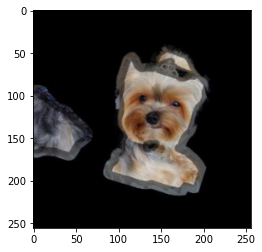

In [3]:
train_b1_img, train_b1_label = next(iter(train_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model with 6 conv layers, weak reg, lr decay

In [4]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)


    


PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.1, inplace=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, pa

In [5]:
learning_rate = 0.001
decay_rate = 0.0003
lr_decay = 0.9    # we'll go for a learning rate decay by a factor of 0.9 every 3 epochs

optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=lr_decay)

num_epochs = 250

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    # to print the current learning rate that is decaying every 5 epochs
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
            
    scheduler.step()
                

            
        


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 79.41143608093262
Current learning rate:0.001
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 69.7626473903656
Current learning rate:0.001
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 55.80986499786377
Current learning rate:0.001
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 57.806447982788086
Current learning rate:0.001
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 58.43844795227051
Current learning rate:0.001
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 58.25927424430847
Current learning rate:0.001
Current training loss:2.9887499809265137
Current training accuracy:0.173828125
Current validation loss:2.812857151031494
Current validation accuracy:0.2264995574951172
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 53.312320947647095
Current learning rate:0.001
Current training loss:2.910912275314331
Current training accuracy:0.1982421875
Curr

Current validation loss:2.829523801803589
Current validation accuracy:0.22470904886722565
Epoch:6
Iteration:1650
Time taken for the last 50 iterations: 55.73493838310242
Current learning rate:0.0008100000000000001
Current training loss:2.3402316570281982
Current training accuracy:0.353515625
Current validation loss:2.344630718231201
Current validation accuracy:0.33124440908432007
Epoch:6
Iteration:1700
Time taken for the last 50 iterations: 57.09509229660034
Current learning rate:0.0008100000000000001
Current training loss:2.1737821102142334
Current training accuracy:0.40087890625
Current validation loss:2.134324312210083
Current validation accuracy:0.39391225576400757
Epoch:6
Iteration:1750
Time taken for the last 50 iterations: 55.296027421951294
Current learning rate:0.0008100000000000001
Current training loss:2.3751213550567627
Current training accuracy:0.32470703125
Current validation loss:2.471299409866333
Current validation accuracy:0.31065353751182556
Epoch:6
Iteration:1800
Tim

Current training loss:1.2668757438659668
Current training accuracy:0.65771484375
Current validation loss:1.732656478881836
Current validation accuracy:0.49865710735321045
Epoch:11
Iteration:3100
Time taken for the last 50 iterations: 58.168816328048706
Current learning rate:0.000729
Current training loss:1.3271137475967407
Current training accuracy:0.64990234375
Current validation loss:1.855449914932251
Current validation accuracy:0.46553269028663635
Epoch:12
Iteration:3150
Time taken for the last 50 iterations: 55.392632246017456
Current learning rate:0.0006561000000000001
Current training loss:1.3022738695144653
Current training accuracy:0.63623046875
Current validation loss:1.8742083311080933
Current validation accuracy:0.4503133296966553
Epoch:12
Iteration:3200
Time taken for the last 50 iterations: 57.74479103088379
Current learning rate:0.0006561000000000001
Current training loss:1.1131221055984497
Current training accuracy:0.73095703125
Current validation loss:1.7426486015319824

Current validation loss:2.6697158813476562
Current validation accuracy:0.34019696712493896
Epoch:17
Iteration:4500
Time taken for the last 50 iterations: 58.84864044189453
Current learning rate:0.00059049
Current training loss:1.1581677198410034
Current training accuracy:0.70947265625
Current validation loss:1.8227883577346802
Current validation accuracy:0.46553269028663635
Epoch:17
Iteration:4550
Time taken for the last 50 iterations: 57.54804468154907
Current learning rate:0.00059049
Current training loss:0.9415544867515564
Current training accuracy:0.77978515625
Current validation loss:1.7570345401763916
Current validation accuracy:0.49507609009742737
Epoch:17
Iteration:4600
Time taken for the last 50 iterations: 58.52489233016968
Current learning rate:0.00059049
Current training loss:0.8801034688949585
Current training accuracy:0.80615234375
Current validation loss:1.7391873598098755
Current validation accuracy:0.5040286779403687
Epoch:17
Iteration:4650
Time taken for the last 50 i

Current training loss:0.45577943325042725
Current training accuracy:0.92138671875
Current validation loss:1.7244987487792969
Current validation accuracy:0.5174574851989746
Epoch:22
Iteration:5950
Time taken for the last 50 iterations: 58.28915452957153
Current learning rate:0.0004782969
Current training loss:0.43389075994491577
Current training accuracy:0.9228515625
Current validation loss:1.7297574281692505
Current validation accuracy:0.522828996181488
Epoch:22
Iteration:6000
Time taken for the last 50 iterations: 56.87056112289429
Current learning rate:0.0004782969
Current training loss:0.4189290702342987
Current training accuracy:0.92822265625
Current validation loss:1.7646766901016235
Current validation accuracy:0.5031334161758423
Epoch:23
Iteration:6050
Time taken for the last 50 iterations: 55.61717867851257
Current learning rate:0.0004782969
Current training loss:0.4309096932411194
Current training accuracy:0.93212890625
Current validation loss:1.792590618133545
Current validati

Epoch:28
Iteration:7350
Time taken for the last 50 iterations: 57.29508376121521
Current learning rate:0.000387420489
Current training loss:0.4673764705657959
Current training accuracy:0.892578125
Current validation loss:2.140638828277588
Current validation accuracy:0.4762757420539856
Epoch:28
Iteration:7400
Time taken for the last 50 iterations: 58.07300281524658
Current learning rate:0.000387420489
Current training loss:0.34674543142318726
Current training accuracy:0.94189453125
Current validation loss:1.8724355697631836
Current validation accuracy:0.49776187539100647
Epoch:28
Iteration:7450
Time taken for the last 50 iterations: 55.97282671928406
Current learning rate:0.000387420489
Current training loss:0.3173563480377197
Current training accuracy:0.95703125
Current validation loss:1.8371636867523193
Current validation accuracy:0.506714403629303
Epoch:28
Iteration:7500
Time taken for the last 50 iterations: 58.11770558357239
Current learning rate:0.000387420489
Current training los

Current training loss:0.16099460422992706
Current training accuracy:0.98193359375
Current validation loss:1.854796051979065
Current validation accuracy:0.5094001889228821
Epoch:33
Iteration:8800
Time taken for the last 50 iterations: 57.82822585105896
Current learning rate:0.00031381059609000004
Current training loss:0.1619405597448349
Current training accuracy:0.9814453125
Current validation loss:1.8240551948547363
Current validation accuracy:0.5192480087280273
Epoch:33
Iteration:8850
Time taken for the last 50 iterations: 58.62053346633911
Current learning rate:0.00031381059609000004
Current training loss:0.15172773599624634
Current training accuracy:0.98486328125
Current validation loss:1.855849266052246
Current validation accuracy:0.506714403629303
Epoch:34
Iteration:8900
Time taken for the last 50 iterations: 56.91767406463623
Current learning rate:0.00031381059609000004
Current training loss:0.32957908511161804
Current training accuracy:0.94482421875
Current validation loss:2.164

Epoch:38
Iteration:10150
Time taken for the last 50 iterations: 55.70791268348694
Current learning rate:0.00028242953648100003
Current training loss:0.13459423184394836
Current training accuracy:0.98291015625
Current validation loss:1.9776774644851685
Current validation accuracy:0.5058191418647766
Epoch:39
Iteration:10200
Time taken for the last 50 iterations: 57.04990339279175
Current learning rate:0.00025418658283290005
Current training loss:0.21890774369239807
Current training accuracy:0.97314453125
Current validation loss:2.095616340637207
Current validation accuracy:0.47806623578071594
Epoch:39
Iteration:10250
Time taken for the last 50 iterations: 58.09349608421326
Current learning rate:0.00025418658283290005
Current training loss:0.1656644344329834
Current training accuracy:0.98193359375
Current validation loss:1.9896416664123535
Current validation accuracy:0.5022381544113159
Epoch:39
Iteration:10300
Time taken for the last 50 iterations: 58.17296504974365
Current learning rate:

Current validation loss:2.316056966781616
Current validation accuracy:0.4261414408683777
Epoch:44
Iteration:11550
Time taken for the last 50 iterations: 57.469979763031006
Current learning rate:0.00022876792454961005
Current training loss:0.1188470795750618
Current training accuracy:0.98681640625
Current validation loss:2.0663845539093018
Current validation accuracy:0.48075202107429504
Epoch:44
Iteration:11600
Time taken for the last 50 iterations: 54.786338329315186
Current learning rate:0.00022876792454961005
Current training loss:0.1206369623541832
Current training accuracy:0.98828125
Current validation loss:2.0018153190612793
Current validation accuracy:0.49239033460617065
Epoch:44
Iteration:11650
Time taken for the last 50 iterations: 56.55872058868408
Current learning rate:0.00022876792454961005
Current training loss:0.10460108518600464
Current training accuracy:0.99365234375
Current validation loss:2.0010933876037598
Current validation accuracy:0.4914950728416443
Epoch:44
Iterat

Current training loss:0.08806785196065903
Current training accuracy:0.99365234375
Current validation loss:2.0240843296051025
Current validation accuracy:0.5219337344169617
Epoch:49
Iteration:12950
Time taken for the last 50 iterations: 58.2926561832428
Current learning rate:0.00018530201888518417
Current training loss:0.07564326375722885
Current training accuracy:0.9951171875
Current validation loss:2.036806583404541
Current validation accuracy:0.5138764381408691
Epoch:49
Iteration:13000
Time taken for the last 50 iterations: 58.027525663375854
Current learning rate:0.00018530201888518417
Current training loss:0.09001119434833527
Current training accuracy:0.99072265625
Current validation loss:2.0324676036834717
Current validation accuracy:0.5147716999053955
Epoch:49
Iteration:13050
Time taken for the last 50 iterations: 51.8794801235199
Current learning rate:0.00018530201888518417
Current training loss:0.09054525941610336
Current training accuracy:0.9921875
Current validation loss:2.08


KeyboardInterrupt



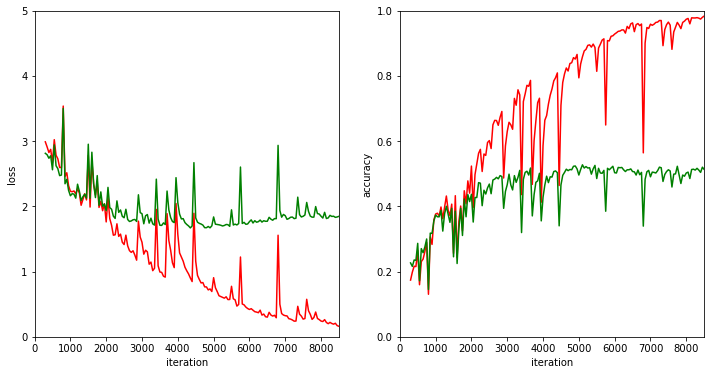

In [6]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,8500)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,8500)
acc_graph.set_ylim(0,1)

plt.show() 